In [11]:
%matplotlib inline
import numpy as np
import torch  as t
import matplotlib.pyplot as plt
import math
import os
from torch.autograd import Variable as V
import random
import gc

def affine_transform(input,mat):
    coor=coordinate_one()
    xyprime=t.tensordot(coor,mat,dims=1)
    return bilinear(input,xyprime)

def coordinate_one():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    onesMatrix = np.ones((xsize,ysize,1))
    coorMatrix = np.concatenate((coor, onesMatrix), axis=2)
    return t.tensor(coorMatrix,device='cuda').double()
    
def bilinear(img,xyprime):
    xp=xyprime[:,:,0]
    yp=xyprime[:,:,1]
    LUX=t.floor(xp).int()
    LUY=t.floor(yp).int()
    LUX=t.where(LUX>xsize-2,t.tensor(xsize-2,device='cuda'),LUX.long())
    LUX=t.where(LUX<1,t.tensor(1,device='cuda'),LUX)
    LUY=t.where(LUY>ysize-2,t.tensor(ysize-2,device='cuda'),LUY.long())
    LUY=t.where(LUY<1,t.tensor(1).cuda(),LUY)
    [a,b]=[yp-LUY.double(),xp-LUX.double()]
    [k00,k01,k10,k11]=[img[LUX,LUY],img[LUX,LUY+1],img[LUX+1,LUY],img[LUX+1,LUY+1]]
    return (1-b)*(a*k01+(1-a)*k00)+b*(a*k11+(1-a)*k10)   

def call_loss(template, moving):
    return t.sum((template-moving)**2)

def randxy(img,rate):
    zeros=t.zeros(img.shape)
    xsize,ysize=img.shape
    i=0
    while i<rate*xsize*ysize:
        randx=random.randint(0,xsize-1)
        randy=random.randint(0,ysize-1)
        if zeros[randx][randy]==0:
            i+=1
            zeros[randx][randy]=1
    return zeros
    
def gradient_check(img, template, matrix, gradient):
    epsilon=1e-13
    difference=t.zeros(matrix.shape)
    for i in range(len(matrix)-1):
        for j in range(len(matrix[0])):
            theltaplus=t.tensor(matrix,device='cuda')
            theltaminus=t.tensor(matrix,device='cuda')
            theltaplus[i][j]+=epsilon
            theltaminus[i][j]-=epsilon
            J_plus=t.sum((template-affine_transform(img,theltaplus))**2)
            J_plus=J_plus.cpu().detach().numpy()
            J_minus=t.sum((template-affine_transform(img,theltaminus))**2)
            J_minus=J_minus.cpu().detach().numpy()
            gradapprox=(J_plus-J_minus)/(2*epsilon)
            numerator = np.linalg.norm(gradient[i][j] - gradapprox) 
            denominator = np.linalg.norm(gradient[i][j]) + np.linalg.norm(gradapprox) 
            difference[i][j]=numerator/denominator
    print(difference)
    
def imshow(img, mov, ref):
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("moving")
    
    plt.subplot(1,3,2)
    plt.imshow(mov)
    plt.title("after transformation")
    
    plt.subplot(1,3,3)
    plt.imshow(ref)
    plt.title("template")
    plt.show()

In [7]:
mov=plt.imread('MRI_2D/fixed1.png')
xsize,ysize=mov.shape
# coordinate_one()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


tensor([[0.7428, 1.0000,    nan],
        [0.7151, 1.0000,    nan],
        [0.0000, 0.0000, 0.0000]])
tensor([[4.2885e-04, 2.3813e-04,        nan],
        [5.0185e-05, 5.5386e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[4.3387e-04, 6.9297e-04,        nan],
        [2.7930e-05, 8.2447e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[2.5546e-04, 3.6294e-03,        nan],
        [9.9491e-06, 1.2778e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[0.0003, 0.0030,    nan],
        [0.0001, 0.0002,    nan],
        [0.0000, 0.0000, 0.0000]])
tensor([[5.0539e-05, 6.7036e-04,        nan],
        [3.1159e-04, 7.5773e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[7.1221e-04, 1.0039e-03,        nan],
        [9.3259e-05, 6.4319e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[0.0005, 0.0023,    nan],
        [0.0001, 0.0004,    nan],
        [0.0000, 0.0000, 0.0000

        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[5.7379e-03, 4.0399e-05,        nan],
        [1.8985e-03, 1.2690e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[3.0433e-03, 6.3344e-06,        nan],
        [3.2767e-04, 2.0754e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[5.5648e-03, 1.5082e-06,        nan],
        [1.0766e-03, 2.0648e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[4.5291e-03, 3.2368e-05,        nan],
        [3.0091e-03, 1.8454e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[1.2179e-02, 2.3050e-05,        nan],
        [9.2896e-03, 1.6626e-05,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[2.2922e-02, 1.2518e-05,        nan],
        [1.5400e-02, 1.1532e-04,        nan],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[9.5289e-03, 8.8837e-05,        nan],
        [2.4111e-03, 1.4226e-04,        nan],
        [0.0000e+00, 0.0000

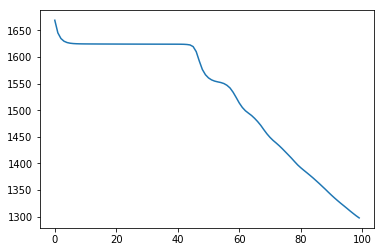

In [14]:
angle=5*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = t.tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]],device='cuda').double()
mov=np.array(plt.imread('MRI_2D/fixed1.png')).astype('double')
xsize,ysize=mov.shape
mov=t.tensor(mov,device='cuda')
template=affine_transform(mov,transformMatrix)
step=5e-8
iter=100
mat=np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]).astype('double')
mat=t.tensor(mat,requires_grad=True,device='cuda')
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    loss=call_loss(template, tmplt)
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    with t.no_grad():
        gradient_check(mov,template,mat.cpu().detach().numpy(),mat.grad.cpu().detach().numpy())
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        
        mat.grad.zero_()

plt.plot(np.arange(iter), losses)

In [41]:
# gc.collect()
t.cuda.empty_cache()

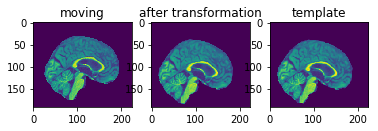

tensor(29.7754, dtype=torch.float64, grad_fn=<SumBackward0>)

In [7]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

In [13]:
transformMatrix = V(t.Tensor([[0.9, -0.0, -0.0],[0.0, 0.9, -0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('MRI_2D/fixed1.png')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
step=5e-8
iter=600
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err**2)   
    loss.backward(retain_graph=True)
    losses.append(loss)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #2 'mat2'

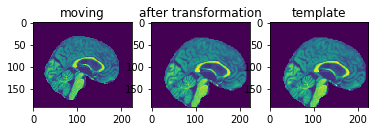

tensor(7.4774, dtype=torch.float64, grad_fn=<SumBackward0>)

In [3]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

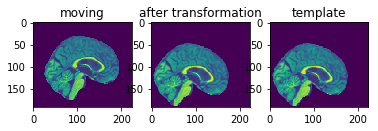

In [5]:

angle=10*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
mat = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
# mat=V(t.tensor([[1.0,0.0,10.0],[0.0,1.10,0],[0.0,0.0,1.0]]).double(),True)
mov=np.array(plt.imread("MRI_2D/fixed1.png"))
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
tmp=affine_transform(mov,mat)
imshow(mov.detach().numpy(),tmp.detach().numpy(),tmp.detach().numpy())

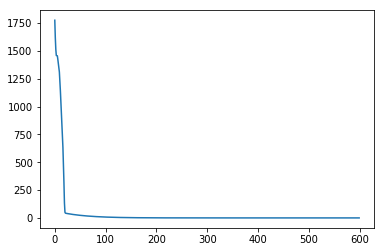

In [6]:
transformMatrix = V(t.Tensor([[1.0, -0.0, 10.0],[0.0, 1.0, 10.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('MRI_2D/fixed1.png')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
step=5e-8
iter=600
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err**2)   
    loss.backward(retain_graph=True)
    losses.append(loss)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]*1e5
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

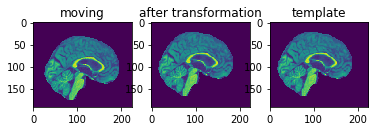

tensor(0.0002, dtype=torch.float64, grad_fn=<SumBackward0>)

In [7]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

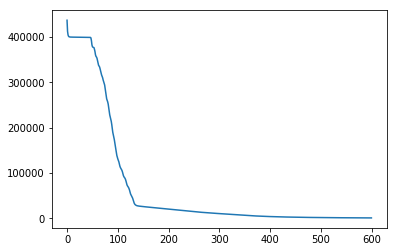

In [6]:
mov=np.zeros((100,100))
mov[25:75, 15:56] = 10
mov[40:70, 45:80] = 20
angle = 5*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
# transformMatrix = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
# mov=plt.imread('MRI_2D/fixed1.png')
xsize,ysize=mov.shape

transformMatrix = V(t.Tensor([[1.0, -0.0, 10.0],[0.0, 1.0, 10.0],[0.0, 0.0, 1.0]]).double(),True)

mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
step=5e-10
iter=600
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err**2)   
    loss.backward(retain_graph=True)
    losses.append(loss)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]*1e4
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

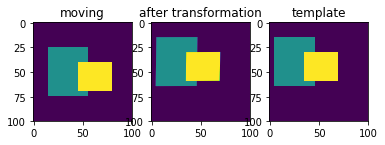

tensor(694.8638, dtype=torch.float64, grad_fn=<SumBackward0>)

In [7]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]